In [414]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle
optimization/btest015.pickle
optimization/btest016.pickle
optimization/btest017.pickle
optimization/btest018.pickle
optimization/btest019.pickle
optimization/btest020.pickle
optimization/btest021.pickle
optimization/btest022.pickle
optimization/btest023.pickle
optimization/btest024.pickle
optimization/btest025.pickle
optimization/btest026.pickle
optimization/btest027.pickle
optimization/btest028.pickle
optimization/btest029.pickle
optimization/btest030.pickle
optimization/btest031.pickle
optimization/btest032.pickle
optimization/btest033.pickle
optimization/b

In [425]:
from backtest import DataParser, MovingWindow
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier



def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 5
tfdict = {"M5":0, "M15":1, "H1":2}
Xl, Xs, yl, ys, odates, poslist = [], [], [], [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[1:]:
        f, _ = mw(pos.open_indx)
        fc = f.Close[:-2]/f.Close[-2]
        fo = f.Open[:-2]/f.Open[-2]
        fh = f.High[:-2]/f.High[-2]
        fl = f.Low[:-2]/f.Low[-2]
        fv = f.Volume[:-2]/f.Volume[-2] if f.Volume[-2] != 0 else f.Volume[:-2]*0
        odate = pd.to_datetime(pos.open_date)
        odate = odate.year*10000 + odate.month*100 + odate.day
        if pos.dir == 1:
            Xl.append(np.hstack([fc, fo, fl, fh, fv, btest.cfg.stops_processor.func.cfg.sl, odate, tfdict[btest.cfg.period]]))
            yl.append(pos.profit)
        else:
            Xs.append(np.hstack([2-fc, 2-fo, 2-fl, 2-fh, fv, btest.cfg.stops_processor.func.cfg.sl, odate, tfdict[btest.cfg.period]])) 
            ys.append(pos.profit) 
        poslist.append(pos)
        
Xs, Xl = np.array(Xs), np.array(Xl)
ys, yl = np.array(ys), np.array(yl)
odates = np.array(odates)

# ids2add = np.random.choice(np.arange(Xs.shape[0]), size=Xl.shape[0] - Xs.shape[0])
# Xs = np.vstack([Xs, Xs[ids2add]])
# ys = np.hstack([ys, ys[ids2add]])
X = np.vstack([Xs, Xl])
y = np.hstack([ys, yl])
print(Xs.shape, Xl.shape, X.shape, ys.shape, yl.shape, y.shape)

SBER 629
ROSN 529
LKOH 532
GMKN 549
GAZP 577
SBER 240
ROSN 135
LKOH 145
GMKN 150
GAZP 152
SBER 1327
ROSN 1151
LKOH 1169
GMKN 1254
GAZP 1296
SBER 537
ROSN 435
LKOH 461
GMKN 444
GAZP 470
SBER 198
ROSN 125
LKOH 124
GMKN 132
GAZP 130
SBER 1124
ROSN 999
LKOH 981
GMKN 1031
GAZP 1080
SBER 477
ROSN 394
LKOH 403
GMKN 408
GAZP 415
SBER 179
ROSN 115
LKOH 113
GMKN 122
GAZP 117
SBER 1016
ROSN 906
LKOH 894
GMKN 929
GAZP 982
(12590, 28) (12941, 28) (25531, 28) (12590,) (12941,) (25531,)


19134 6397
000 profit M5 : +329.3 ->  +324.6 --
000 profit M15: +320.9 ->  +303.2 --
000 profit H1 : +268.9 ->  +286.7 OK
000 f1_train: 0.50 f1_test: 0.50
[329.26997044 320.8583787  268.86755492]  ->  [324.59131282 303.18497843 286.74892094]
[-0.01420918 -0.05508162  0.06650622]
f1_train: 0.50 f1_test: 0.50 ration: 1.00
av. profit boost: -0.004864757139290981


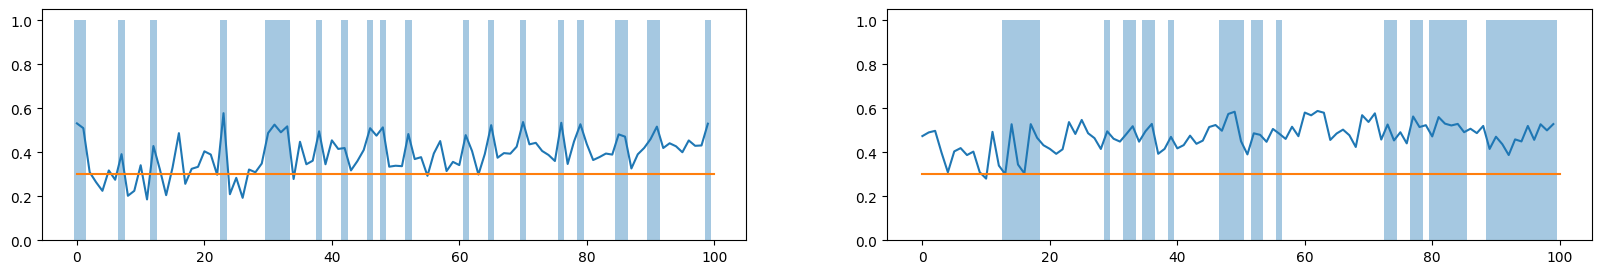

In [430]:
nitrers = 1
test_split = 0.25
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    ids = np.arange(X.shape[0])
    # np.random.shuffle(ids)
    test_size = int(X.shape[0]*test_split)
    ids_test, odates_testset, odates = [], set(), X[:, -2]
    while len(ids_test) < test_size:
        ix = np.random.randint(0, X.shape[0])
        d = odates[ix]
        if d not in odates_testset:
            ii = ids[odates == d]
            ids_test += ii.tolist()
            odates_testset.add(d)
    ids_train = [ix for ix in ids if ix not in ids_test]    
        
    # ids_test, ids_train = ids[:test_size], ids[test_size:]
    X_train, X_test, y_train, y_test = X[ids_train], X[ids_test], y[ids_train], y[ids_test]
    tf_test = X_test[:, -1]
    X_train = X_train[:, :-2]
    X_test = X_test[:, :-2]
    profs_test = y_test
    profs_train = y_train
    y_train = (y_train > 0).astype(int)
    y_test = (y_test > 0).astype(int)
    print(X_train.shape[0], X_test.shape[0])

    # scaler = StandardScaler() 
    # scaler.fit(X_train) 
    # X_train = scaler.transform(X_train) 
    # X_test = scaler.transform(X_test) 
    
    # X_add = X_train + np.random.random(X_train.shape)*0.1
    # X_train = np.vstack([X_train, X_add])
    # y_train = np.hstack([y_train, y_train])

    # evals_result = {}
    # model = lgb.train(params=dict(objective="binary", 
    #                             # metric="auc",
    #                             # num_leaves=2, 
    #                             max_depth=3,
    #                             verbose=-1), 
    #                   train_set=lgb.Dataset(X_train, label=y_train),
    #                   valid_sets=[lgb.Dataset(X_test, label=y_test)],
    #                   num_boost_round=500,
    #                   feval=lgb_f1_score,
    #                   # evals_result=evals_result,
    #                   # verbose_eval=False,
    #                   callbacks=[log_evaluation(-1)]
    #                   )
    # lgb.plot_metric(evals_result, metric='f1')

    model = RandomForestClassifier(max_depth=16, n_estimators=400, min_samples_leaf=50, class_weight="balanced",)
    model.fit(X_train, y_train)
    
    if len(X_train):
        # p_train = model.predict(X_train)
        p_train = model.predict_proba(X_train)[:, 1]
        threshold = 0.3#np.percentile(p_train, 10)
        metrics[0, i] = f1_score(p_train > threshold, y_train)
    # p_test = model.predict(X_test)
    p_test = model.predict_proba(X_test)[:, 1]
    metrics[1, i] = f1_score(p_test > threshold, y_test)

    for j in range(3):
        ids = tf_test == j
        pprofits[j, i] = (profs_test[ids]*(p_test[ids]>=threshold)).sum()
        gprofits[j, i] = profs_test[ids].sum()
        print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    print(f"{i:03} f1_train: {metrics[0, i]:4.2f} f1_test: {metrics[1, i]:4.2f}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)
f1_mean = metrics.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"f1_train: {f1_mean[0]:4.2f} f1_test: {f1_mean[1]:4.2f} ration: {f1_mean[1]/f1_mean[0]:4.2f}")
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100])
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100])
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])

In [394]:
set(X_train[:, -1].astype(int)).intersection(set(X_test[:, -1].astype(int)))

{1, 2, 3}

In [396]:
print(" ".join(map("{:6.4f}".format, model.feature_importances_)))

0.2068 0.1769 0.2054 0.1632 0.1462 0.1016


In [391]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(1112, 3653, 3682, 3682)

In [ ]:
import mplfinance as mpf

ticker = "GAZP"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="metatrader"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [47]:
prediction

array([[0.49287947, 0.50712053]])